In [1]:
import numpy as np

import matplotlib as mpl

import matplotlib.pyplot as plt
plt.ion()

# for the symbolic manipulation of jacobian
import sympy as sp
from sympy import init_printing
init_printing() # doctest: +SKIP
# from sympy import symbols
# from sympy import sin, cos, asin, acos, pi, atan2, sqrt
from sympy.utilities.lambdify import lambdify
# from sympy import Matrix

from scipy.optimize import minimize
from scipy.optimize import fsolve

In [2]:
l_1 = 9.0
l_2 = 16.0
w = 7.0

In [3]:
(x, x_1, x_2,
 y, y_1, y_2) = sp.symbols("""x x_1 x_2
                            y y_1 y_2""", real = True) #Here we define two pairs of intermediate variables(x_1, y_1) and (x_2, y_2) which are the joints' coord

(theta_L, 
 theta_R) = sp.symbols("""theta_L 
                         theta_R""", real = True)

In [4]:
results = sp.solve([(x-x_1)**2 + (y-y_1)**2 -l_2**2, (x-x_2)**2 + (y-y_2)**2 -l_2**2 ],[x,y]) #Equation established by geometry relations

In [5]:
#Solve for (x,y)=f(theta_L, theta_R)
x = results[1][0].subs([(x_1, l_1*sp.cos(theta_L) + w/2), (y_1, l_1*sp.sin(theta_L)), (x_2, l_1*sp.cos(theta_R) - w/2),(y_2, l_1*sp.sin(theta_R))])
y = results[1][1].subs([(x_1, l_1*sp.cos(theta_L) + w/2), (y_1, l_1*sp.sin(theta_L)), (x_2, l_1*sp.cos(theta_R) - w/2),(y_2, l_1*sp.sin(theta_R))])
#x_1 = l_1*sp.cos(theta_L) + w/2
#y_1 = l_1*sp.sin(theta_L)
#x_2 = l_1*sp.cos(theta_R) - w/2
#y_2 = l_1*sp.sin(theta_R)

In [6]:
FK_fivebar = sp.Matrix([  [ x ], 
                          [ y ]  ]) #Put it into a matrix so we can compute Jacobian
FK_fivebar

⎡     ⎛                                ⎛       _______________________________
⎢     ⎜                                ⎜      ╱  ⎛                    2       
⎢     ⎜                                ⎜0.5⋅╲╱  -⎝(9.0⋅cos(θ_L) + 3.5)  - 2.0⋅
⎢-0.5⋅⎜(18.0⋅sin(θ_L) - 18.0⋅sin(θ_R))⋅⎜──────────────────────────────────────
⎢     ⎜                                ⎜                                      
⎢     ⎝                                ⎝                                      
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                     ________
⎢                                                                    ╱  ⎛     
⎢                                                              0.5⋅╲╱  -⎝(9.0⋅
⎢                                                   

In [7]:
J_fivebar = FK_fivebar.jacobian([theta_L, theta_R])
J_fivebar

⎡      ⎛                                ⎛         ____________________________
⎢      ⎜                                ⎜        ╱  ⎛                    2    
⎢      ⎜                                ⎜  0.5⋅╲╱  -⎝(9.0⋅cos(θ_L) + 3.5)  - 2
⎢      ⎜                                ⎜                                     
⎢  0.5⋅⎜(18.0⋅sin(θ_L) - 18.0⋅sin(θ_R))⋅⎜- ───────────────────────────────────
⎢      ⎜                                ⎜                                     
⎢      ⎜                                ⎜                                     
⎢      ⎝                                ⎝                                     
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [8]:
J_fivebar_fast = lambdify((theta_L, theta_R), J_fivebar)
FK_fivebar_fast = lambdify((theta_L, theta_R), FK_fivebar)

In [9]:
q1 = np.linspace(-np.pi, np.pi, 100)
q2 = np.linspace(-np.pi, np.pi, 100)
proprioception = np.zeros((q1.shape[0], q2.shape[0]))
force_production = np.zeros((q1.shape[0], q2.shape[0]))
workspace = np.zeros((q1.shape[0], q2.shape[0], 2))


for j, q1_ang in enumerate(q1):
    for k, q2_ang in enumerate(q2):

        
        workspace[j,k, :] = FK_fivebar_fast(q1_ang, q2_ang).T
        
        J_current = J_fivebar_fast(q1_ang, q2_ang)

        u, s, v = np.linalg.svd(J_current)
        
        proprioception[j, k] = s[1]**2 ## Since the svd returns singular values in decreasing magnitude order, s[1] is the smallest of the two 
        force_production[j, k] = 1/s[0]**2
        

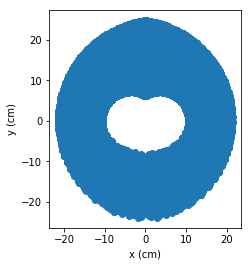

In [10]:
plt.clf()
plt.plot(np.ravel(workspace[:,:,0]), np.ravel(workspace[:,:,1]), 'o')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.gca().set_aspect('equal')

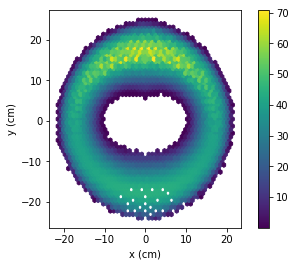

In [11]:
plt.clf()
plt.hexbin(np.ravel(workspace[:,:,0]), np.ravel(workspace[:,:,1]), C = np.ravel(proprioception), gridsize = 50)
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.gca().set_aspect('equal')
plt.colorbar()

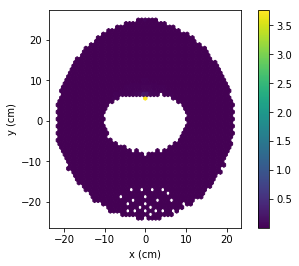

In [12]:
plt.clf()
plt.hexbin(np.ravel(workspace[:,:,0]), np.ravel(workspace[:,:,1]), C = np.ravel(force_production), gridsize = 50)
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.gca().set_aspect('equal')
plt.colorbar()

### Work space measurement is in Zhaoqiang's .ipynb file.